# SBU CSE 352 - HW 1.2 - Search: Solving a Maze Using a Goal-based Agent


All student names in group: Safwan Kader, Dylan Lai, Jerry Xiao

I understand that my submission needs to be my own group's work: SK, DL, JX

I understand that ChatGPT / Copilot / other AI tools are not allowed: SK, DL, JX

---

## Instructions

Total Points: 100

Complete this notebook. Use the provided notebook cells and insert additional code and markdown cells as needed. Only use standard packages (numpy, scipy, and built-in packages like random). Submit the completely rendered notebook as a HTML file.


## Introduction

The agent has a map of the maze it is in and the environment is assumed to be **deterministic, discrete, and known.** The agent must use the map to plan a path through the maze from the starting location $S$ to the goal location $G$.  This is a planing exercise for a goal-based agent, so you do not need to implement an environment, just use the map to search for a path. Once the plan is made, the agent in a deterministic environment (i.e., the transition function is deterministic with the outcome of each state/action pair fixed and no randomness) can just follow the path and does not need to care about the percepts.
This is also called an **[open-loop system](https://en.wikipedia.org/wiki/Open-loop_controller).**
The execution phase is trivial and we do not implement it in this exercise.

Tree search algorithm implementations that you find online and used in general algorithms courses have often a different aim. These algorithms assume that you already have a tree in memory. We are interested in dynamically creating a search tree with the aim of finding a good/the best path from the root noteto the goal state. Follow the pseudo code presented in the text book (and replicated in the slides) closely. Ideally, we would like to search only a small part of the maze, i.e., create a search tree with as few nodes as possible.

Several mazes for this exercise are stored as text files. Here is the small example maze:

In [2]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
!git clone https://github.com/stanleybak/CS7320-AI.git
%cd CS7320-AI/Search
!ls

fatal: destination path 'CS7320-AI' already exists and is not an empty directory.


/Users/safkader/Classes/CSE352/Homeworks/HW1/CS7320-AI/Search
CS7320-AI                         empty_2_maze.txt
Explore_heuristics.ipynb          empty_maze.txt
L_maze.txt                        large_maze.txt
Maze.ipynb                        loops_maze.txt
Maze_BFS_vs_A_Star.ipynb          maze_helper.py
Maze_Example-Animation.ipynb      medium_maze.txt
Maze_Example-Animation_full.ipynb open_maze.txt
Maze_Example.ipynb                small_maze.txt
README.md                         wall_maze.txt
__pycache__


/Users/safkader/Library/Python/3.9/lib/python/site-packages/IPython/core/magics/osm.py:417: UserWarning: using dhist requires you to install the `pickleshare` library.
  self.shell.db['dhist'] = compress_dhist(dhist)[-100:]


In [3]:
# First download the repo and change the directory to be the one where the dependencies are.
# You should only need to do this once per session. If you want to reset, do Runtime -> Disconnect and Delete Runtime
# You can always do !pwd to see the current working directory and !ls to list current files.
#!git clone https://github.com/stanleybak/CS7320-AI.git

In [4]:
# if the below fails to open, then small_maze.txt is not in the current working directory (see above code block)
with open("small_maze.txt", "r") as f:
    maze_str = f.read()
print(maze_str)

XXXXXXXXXXXXXXXXXXXXXX
X XX        X X      X
X    XXXXXX X XXXXXX X
XXXXXX     S  X      X
X    X XXXXXX XX XXXXX
X XXXX X         X   X
X        XXX XXX   X X
XXXXXXXXXX    XXXXXX X
XG         XX        X
XXXXXXXXXXXXXXXXXXXXXX



__Note:__ The mazes above contains cycles and therefore the state space may not form proper trees unless cycles are prevented. Therfore, you will need to deal with cycle detection in your code.

## Parsing and pretty printing the maze

The maze can also be displayed in color using code in the module [maze_helper.py](maze_helper.py). The code parses the string representing the maze and converts it into a `numpy` 2d array which you can use in your implementation. Position are represented as a 2-tuple of the form `(row, col)`.

In [5]:
import maze_helper as mh

maze = mh.parse_maze(maze_str)

# look at a position in the maze by subsetting the 2d array
print("Position(0,0):", maze[0, 0])

# there is also a helper function called `look(maze, pos)` available
# which uses a 2-tuple for the position.
print("Position(8,1):", mh.look(maze, (8, 1)))

Position(0,0): X
Position(8,1): G


A helper function to visualize the maze is also available.

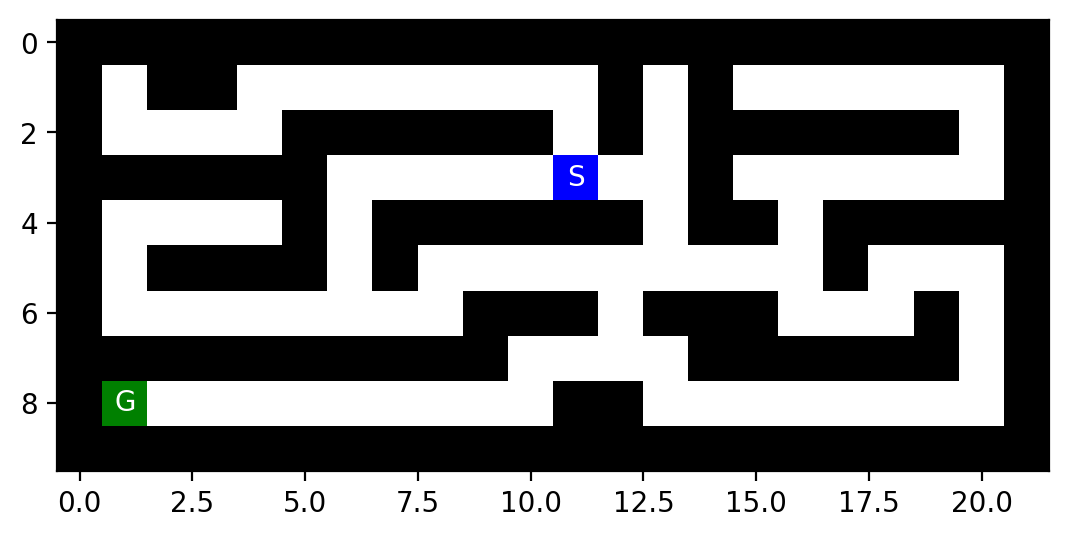

In [6]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
# use higher resolution images in notebook

mh.show_maze(maze)

Find the position of the start and the goal using the helper function `find_pos()`

In [7]:
print("Start location:", mh.find_pos(maze, what = "S"))
print("Goal location:", mh.find_pos(maze, what = "G"))

Start location: (3, 11)
Goal location: (8, 1)


Helper function documentation.

In [8]:
help(mh)

Help on module maze_helper:

NAME
    maze_helper

DESCRIPTION
    Code for the Maze Assignment by Michael Hahsler
    Usage: 
        import maze_helper as mh
        mh.show_some_mazes()

FUNCTIONS
    find_pos(maze, what='S')
        Find start/goal in a maze and returns the first one. 
        Caution: there is no error checking!
        
        Parameters:
        maze: a array with characters prodced by parse_maze()
        what: the letter to be found ('S' for start and 'G' for goal)
        
        Returns:
        a tupple (x, y) for the found position.
    
    look(maze, pos)
        Look at the label of a square with the position as an array of the form (x, y).
    
    parse_maze(maze_str)
        Convert a maze as a string into a 2d numpy array
    
    show_maze(maze, fontsize=10)
        Display a (parsed) maze as an image.
    
    welcome()
        Welcome message.

FILE
    /Users/safkader/Classes/CSE352/Homeworks/HW1/CS7320-AI/Search/maze_helper.py




## Tree structure

Here is an implementation of the basic node structure for the search algorithms (see Fig 3.7 on page 73). I have added a method that extracts the path from the root node to the current node. It can be used to get the path when the search is completed.

In [9]:
class Node:
    def __init__(self, pos, parent, action, cost):
        self.pos = tuple(pos)    # the state; positions are (row,col)
        self.parent = parent     # reference to parent node. None means root node.
        self.action = action     # action used in the transition function (root node has None)
        self.cost = cost         # for uniform cost this is the depth. It is also g(n) for A* search

    def __str__(self):
        return f"Node - pos = {self.pos}; action = {self.action}; cost = {self.cost}"
    
    def __lt__(self, other):
        return self.cost < other.cost

    def get_path_from_root(self):
        """returns nodes on the path from the root to the current node."""
        node = self
        path = [node]

        while not node.parent is None:
            node = node.parent
            path.append(node)

        path.reverse()

        return(path)

If needed, then you can add more fields to the class like the heuristic value $h(n)$ or $f(n)$.

Examples for how to create and use a tree and information on memory management can be found [here](../HOWTOs/trees.ipynb).

# Tasks

The goal is to:

1. Implement the following search algorithms for solving different mazes:

    - Breadth-first search (BFS)
    - Depth-first search (DFS)
    - Greedy best-first search (GBFS)
    - A* search

2. Run each of the above algorithms on the
    - [small maze](./CS3720-AI/Search/small_maze.txt),
    - [medium maze](medium_maze.txt),
    - [large maze](large_maze.txt),
    - [open maze](open_maze.txt),
    - [wall maze](wall_maze.txt),
    - [loops maze](loops_maze.txt),
    - [empty maze](empty_maze.txt), and
    - [empty 2_maze](empty_2_maze.txt).
    
3. For each problem instance and each search algorithm, report the following in a table:

    - The solution and its path cost
    - Total number of nodes expanded
    - Maximum tree depth
    - Maximum size of the frontier

4. Display each solution by marking every maze square (or state) visited and the squares on the final path.

## General [10 Points]

1. Your implementation can use libraries like math, numpy, scipy, but not libraries that implement inteligent agents or complete search algorithms. Try to keep the code simple! In this course, we want to learn about the algorithms and we often do not need to use object-oriented design.
2. You notebook needs to be formated professionally.
    - Add additional markdown blocks for your description, comments in the code, add tables and use mathplotlib to produce charts where appropriate
    - Do not show debugging output or include an excessive amount of output.
    - Check that your PDF file is readable. For example, long lines are cut off in the PDF file. You don't have control over page breaks, so do not worry about these.
3. Document your code. Add a short discussion of how your implementation works and your design choices.

## Task 1: Defining the search problem and determining the problem size [10 Points]

Define the components of the search problem:

* Initial state
* Actions
* Transition model
* Goal state
* Path cost

Use verbal descriptions, variables and equations as appropriate.

*Note:* You can swich the next block from code to Markdown and use formating.

- **Initial State (S₀):** 
  - The initial state is the starting position of the agent in the maze.

- **Actions (A):** 
  - The actions are the possible movements the agent can take in the maze, such as moving one step in any of the four directions (up, down, left, right).

- **Transition Model (Result function):** 
  - The result function defines the outcome of taking a specific action in a given state. It determines the next state based on the current state and the action taken.

- **Goal State (G):** 
  - The goal state is the configuration of the maze where the agent has reached the destination.

- **Path Cost (Cost function):** 
  - The cost function assigns a cost to each step or action in the maze, influencing the search algorithms to find the path with the lowest cumulative cost.

Give some estimates for the problem size:

* $n$: state space size
* $d$: depth of the optimal solution
* $m$: maximum depth of tree
* $b$: maximum branching factor

Describe how you would determine these values for a given maze.

- **State Space Size ($n$):** 
  - Count the number of cells or squares in the maze.

- **Depth of Optimal Solution ($d$):** 
  - Find the shortest path from the start to the goal in the maze.

- **Maximum Depth of Tree ($m$):** 
  - This can be determined by exploring the entire search tree until the goal is found.

- **Maximum Branching Factor ($b$):** 
  - Count the maximum number of accessible neighboring cells for any given cell in the maze.

## Task 2: Uninformed search: Breadth-first and depth-first [40 Points]

Implement these search strategies. Follow the pseudocode in the textbook/slides. You can use the tree structure shown above to extract the final path from your solution.

__Notes:__
* You can find maze solving implementations online that use the map to store information. While this is an effective idea for this two-dimensional navigation problem, it typically cannot be used for other search problems. Therefore, follow the textbook and only store information in the tree created during search, and use the `reached` and `frontier` data structures.
* DFS can be implemented using the BFS tree search algorithm and simply changing the order in which the frontier is expanded (this is equivalent to best-first search with path length as the criterion to expand the next node). However, to take advantage of the significantly smaller memory footprint of DFS, you need to implement DFS in a different way without a `reached` data structure and by releasing the memory for nodes that are not needed anymore.
* If DFS does not use a `reached` data structure, then its cycle checking abilities are limited. Remember, that DFS is incomplete if cycles cannot be prevented. You will see in your experiments that open spaces are a problem.


 small_maze.txt 

depth first search



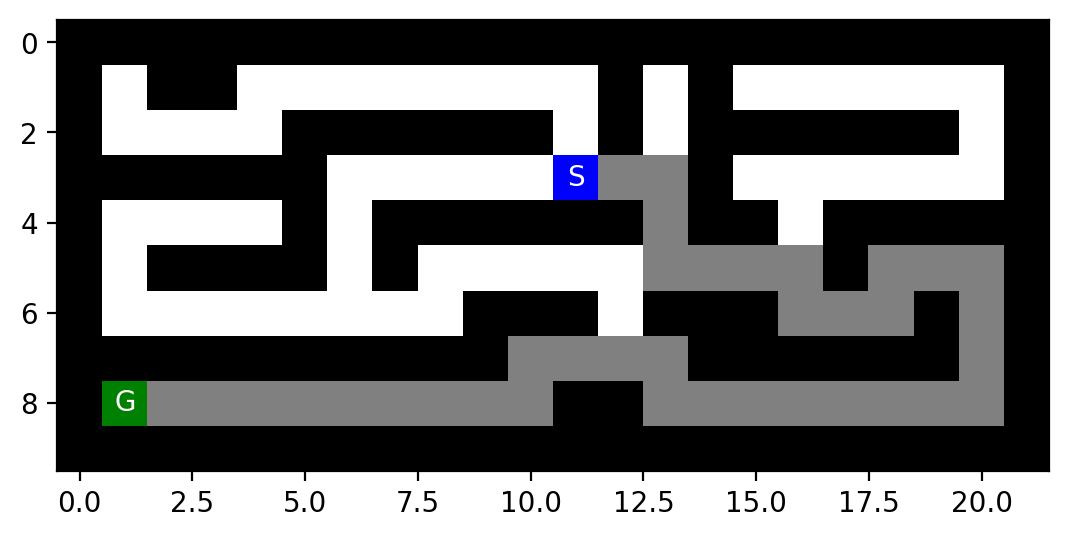

breadth first search



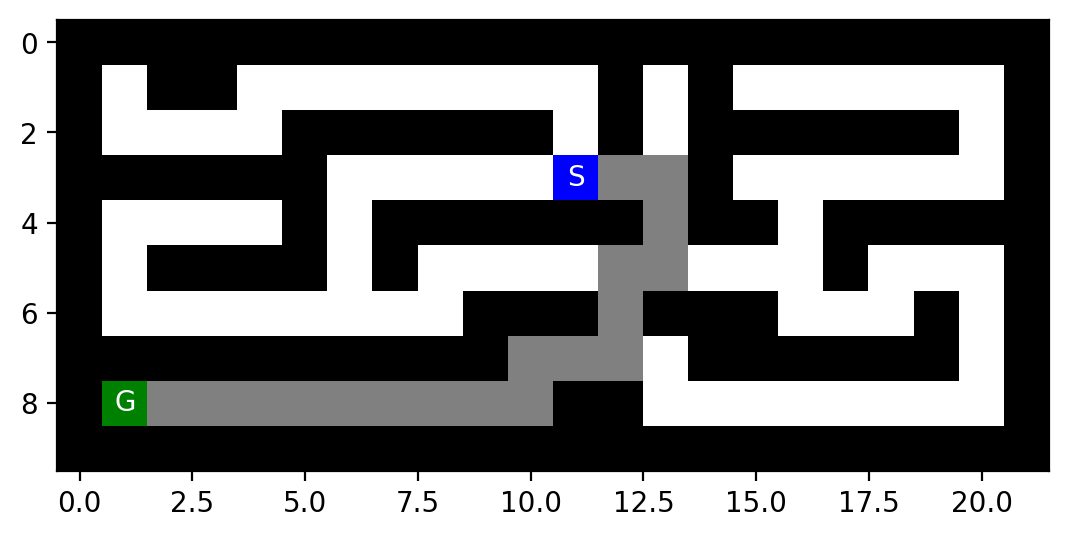


 medium_maze.txt 

depth first search



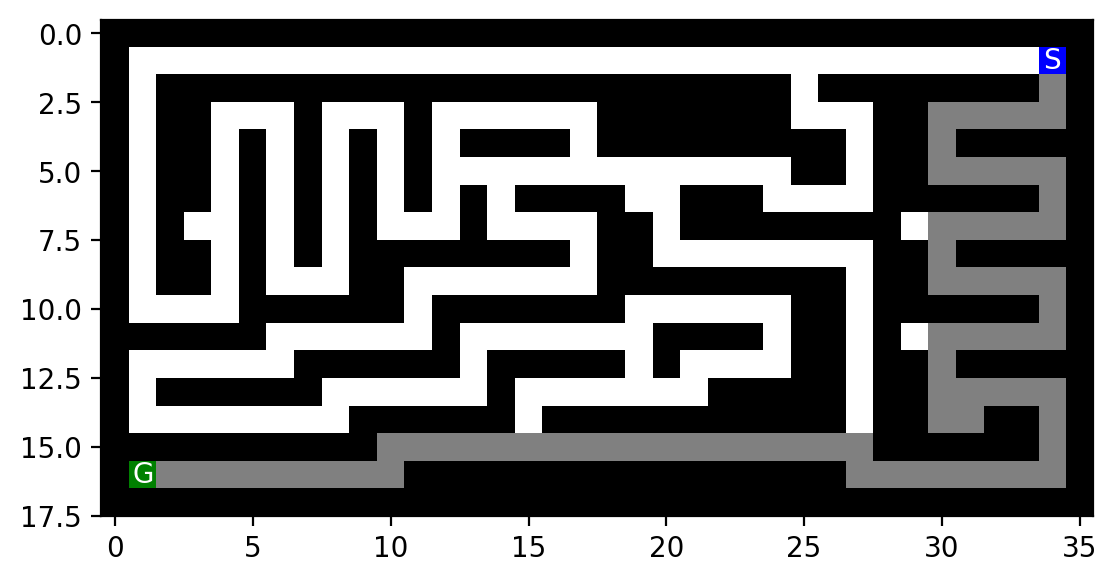

breadth first search



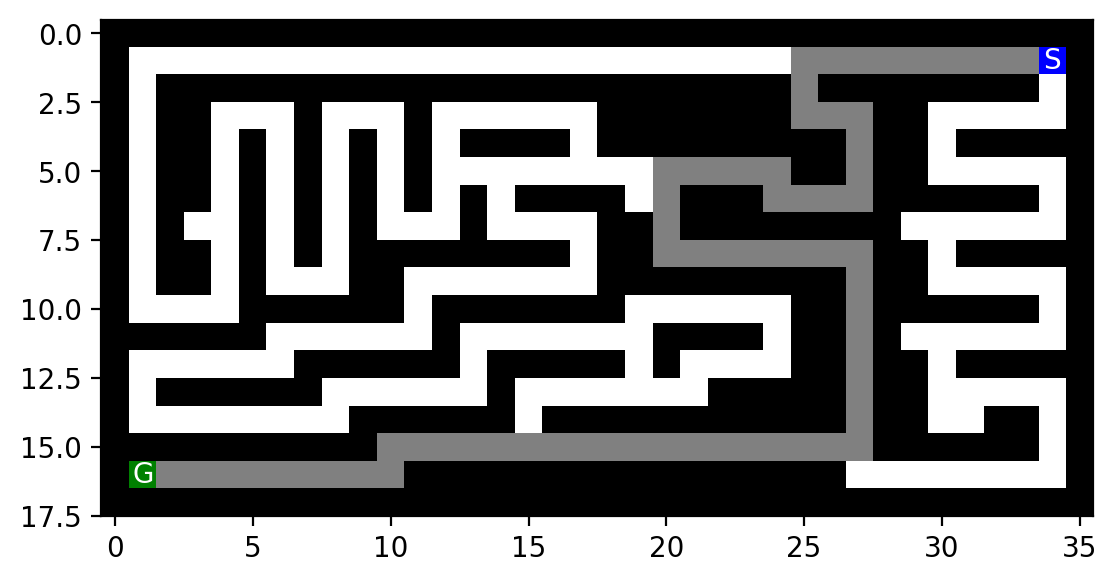


 large_maze.txt 

depth first search



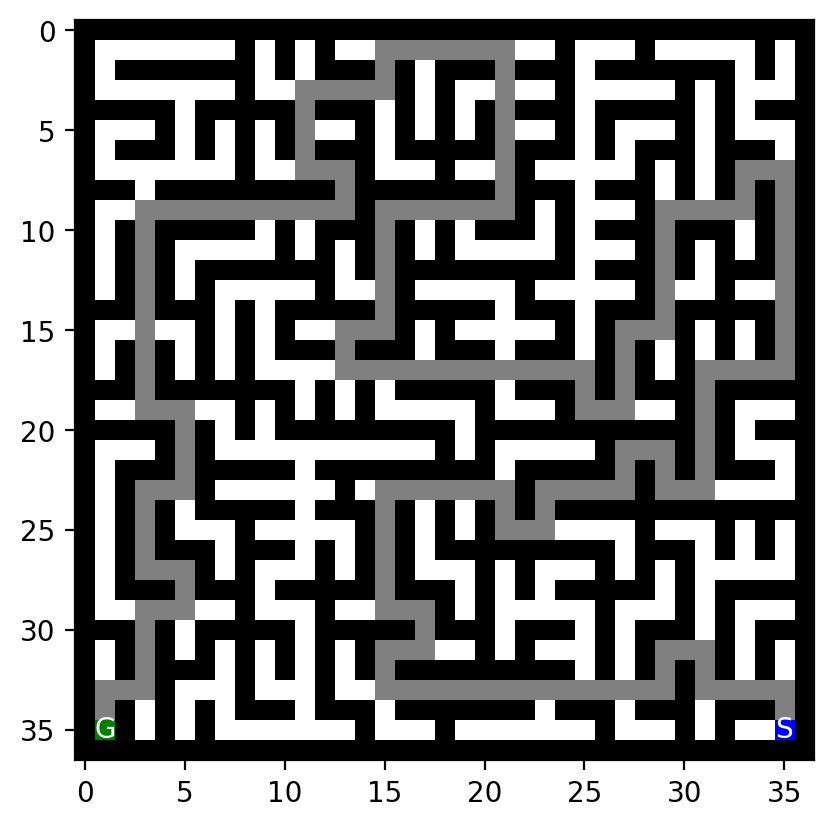

breadth first search



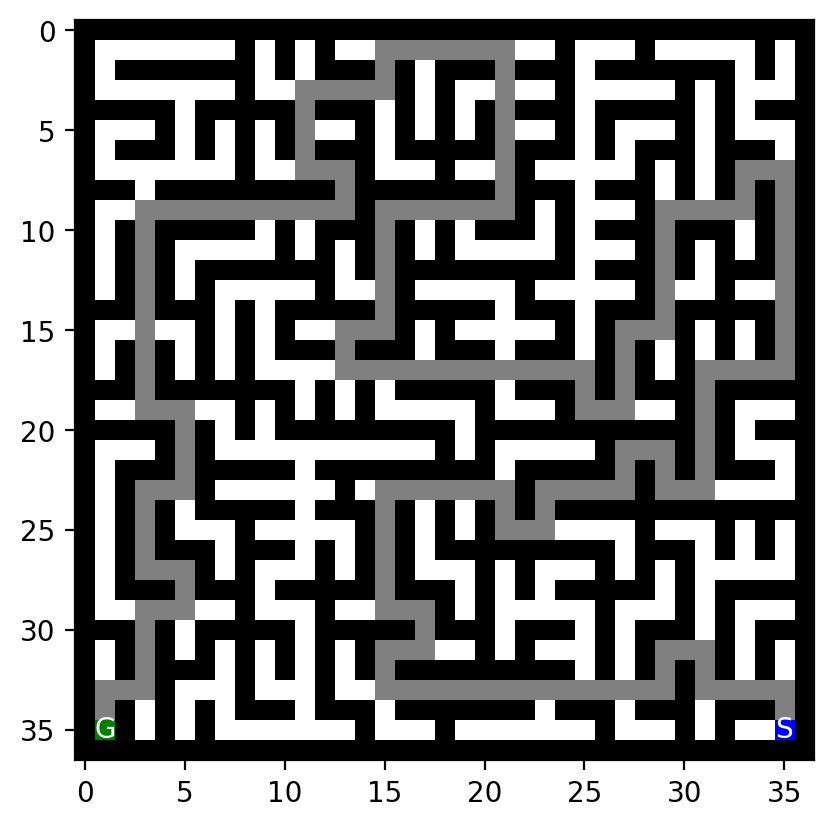


 wall_maze.txt 

depth first search



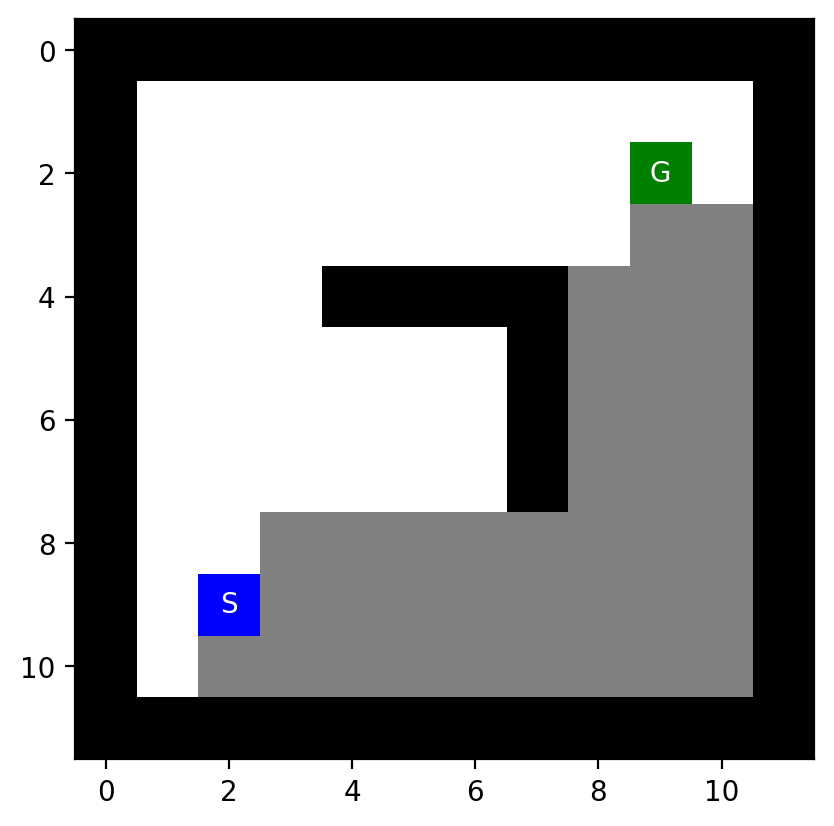

breadth first search



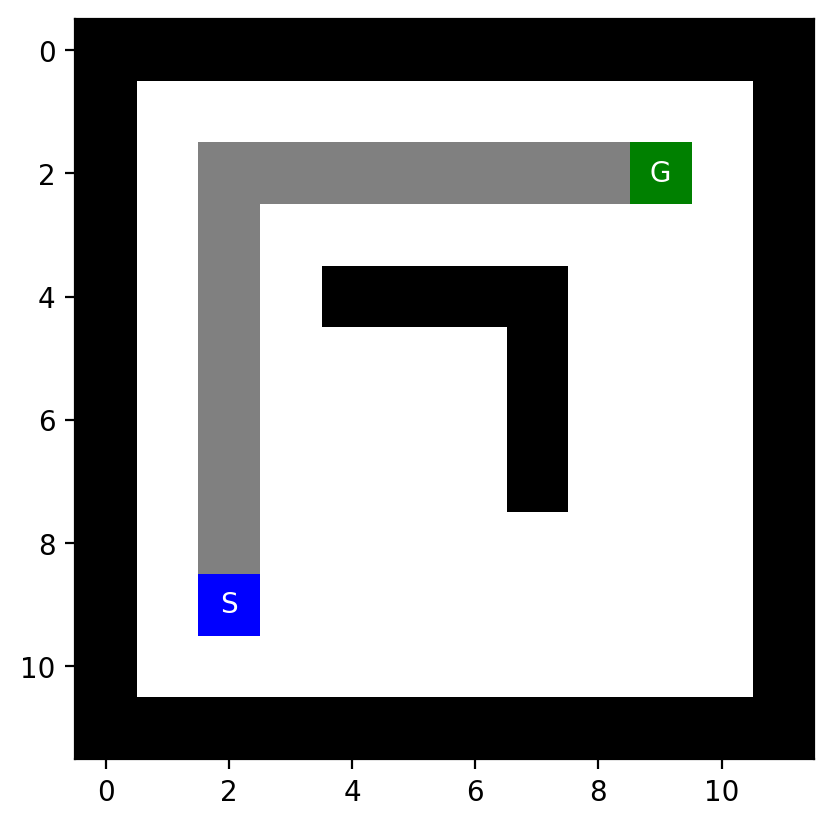


 loops_maze.txt 

depth first search



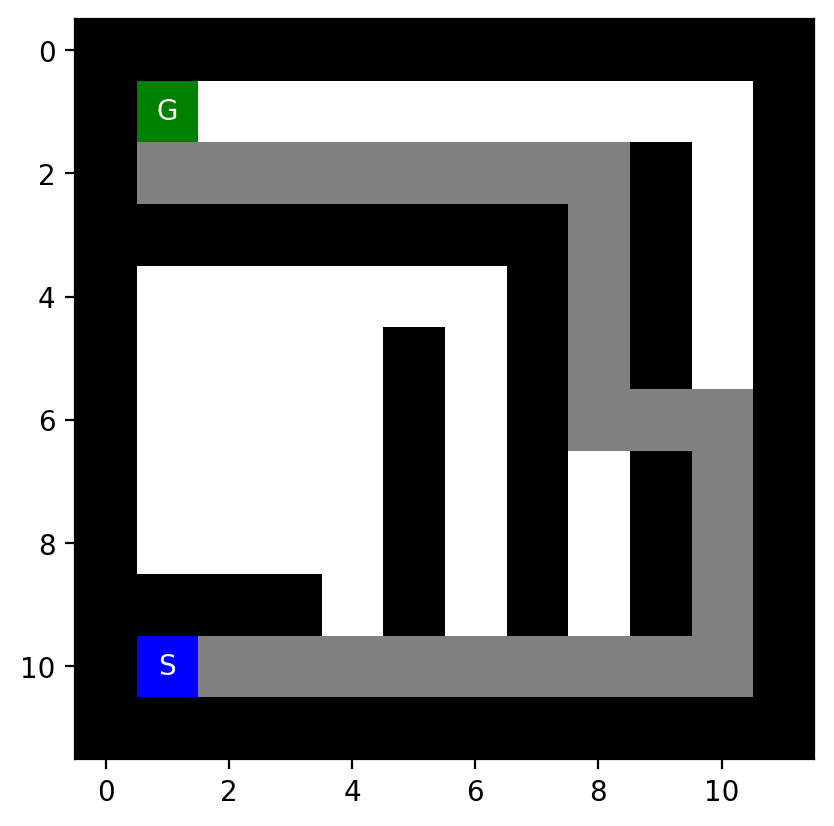

breadth first search



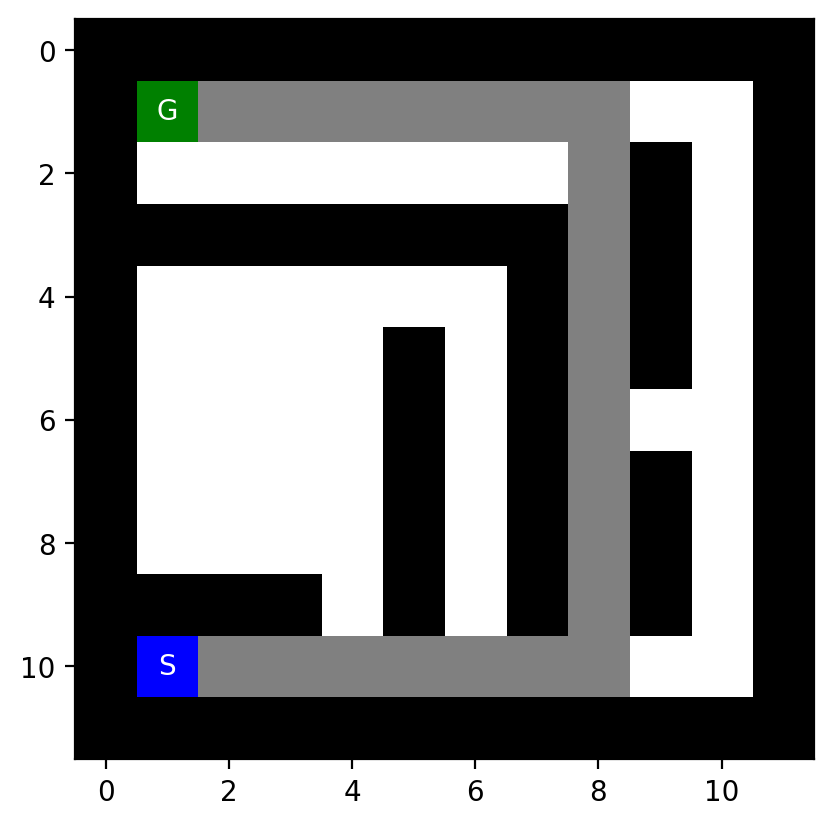


 empty_maze.txt 

depth first search



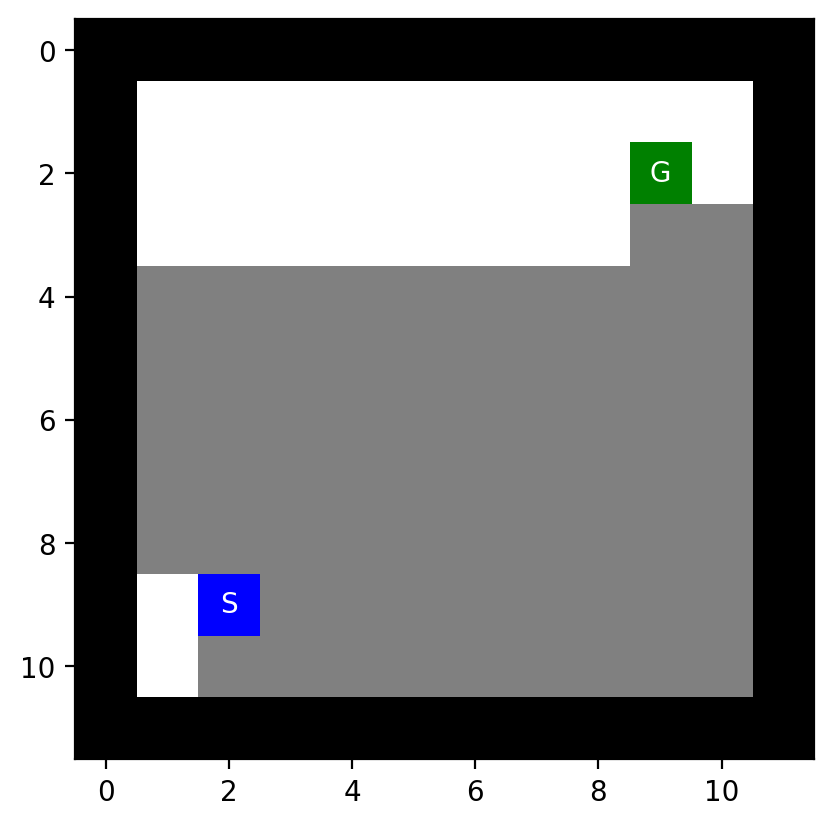

breadth first search



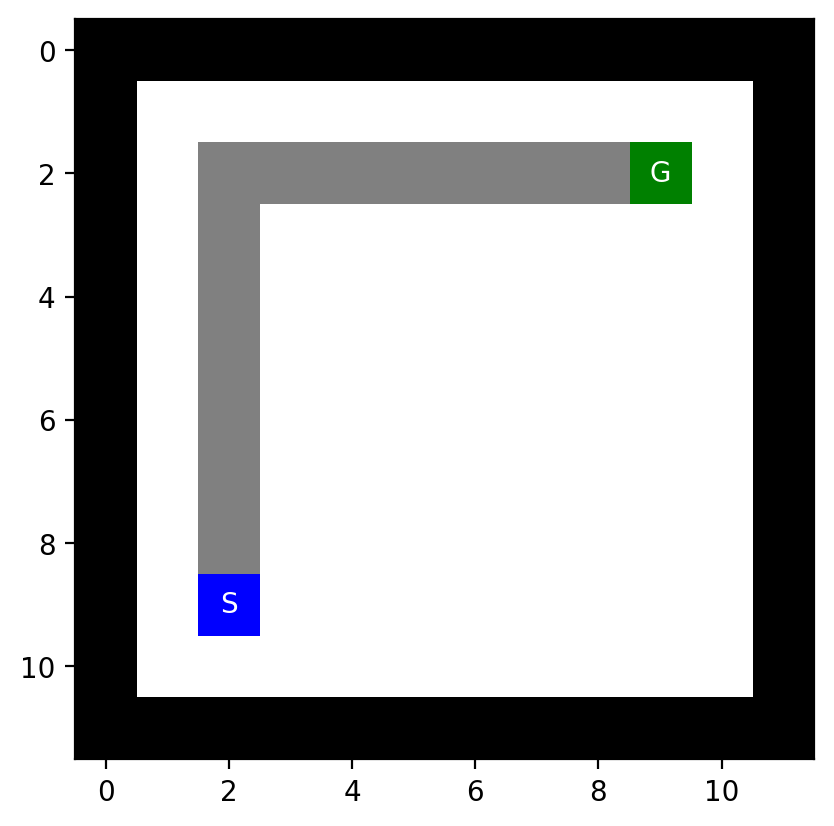


 empty_2_maze.txt 

depth first search



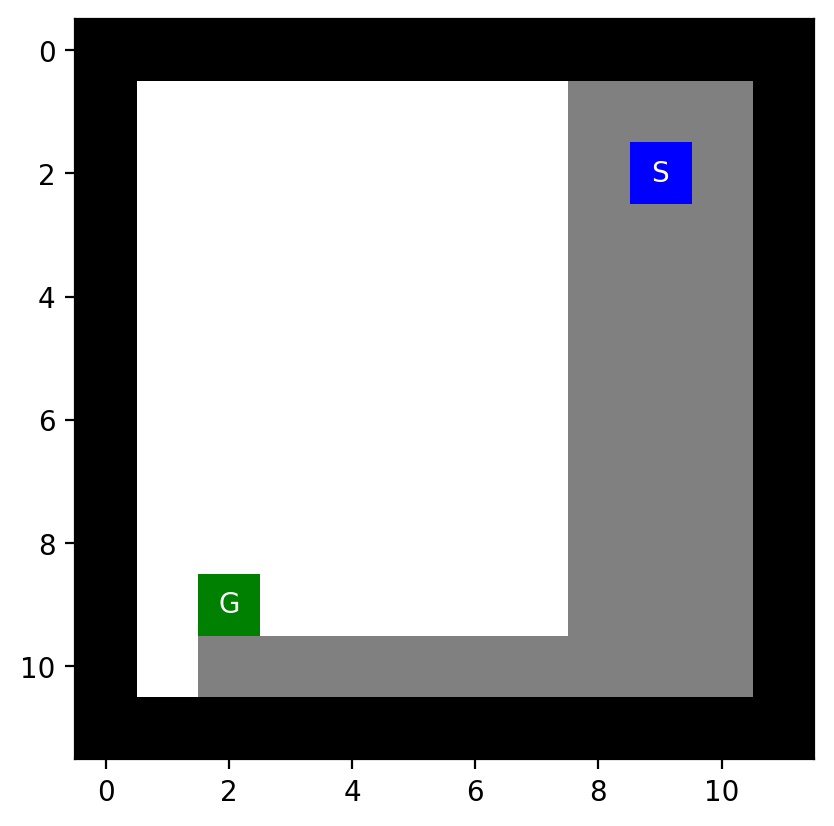

breadth first search



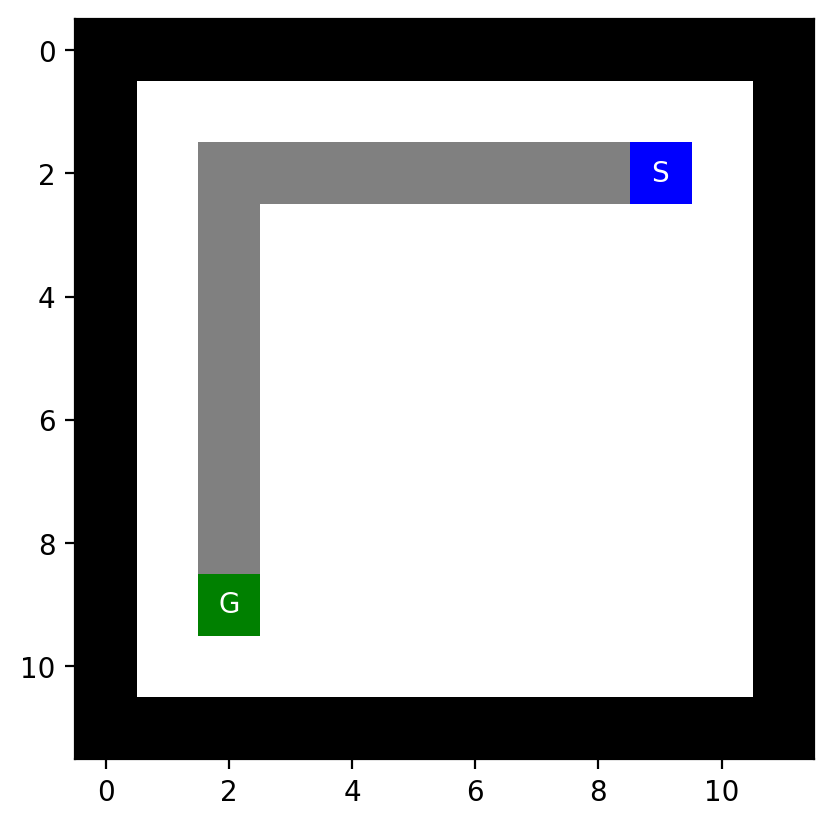

In [10]:
from collections import deque 

# DFS Implementation

def dfs_maze_search(maze):
    """depth first search of the maze which returns the path, """
    root = Node(mh.find_pos(maze,what = 'S'), None, None, 0)
    goal_node = mh.find_pos(maze, what = 'G')
    
    if root.pos == goal_node:
        return root.get_path_from_root()
    
    # initialize frontier stack
    frontier = [root]
    
    # keep track of one node at a time, only hold nodes with multiple children
    
    while frontier:
        # pop the last node
        cur_node = frontier.pop()
        
        children = get_surrounding_positions(maze,cur_node.pos)
        path = [node.pos for node in cur_node.get_path_from_root()]
        
        for child in children:
            if not child in path:
                
                # create a child node
                s = Node(child, cur_node, None, cur_node.cost + 1)
                # get path from the root
                # return if goal found
            
                if child == goal_node:
                    return s.get_path_from_root()
                frontier.append(s)
        
    return None

# BFS Implementation

def bfs_maze_search(maze):
    # use maze helper to get start position
    root = Node(mh.find_pos(maze,what = 'S'), None, None, 0)
    goal_node = mh.find_pos(maze, what = 'G')

    if root.pos == goal_node:
        return root.get_path_from_root()

    # initialize frontier queue and reached
    frontier = deque([root])
    reached = {root}

    while frontier:
        # pop from front of queue
        cur_node = frontier.popleft()
        # children are all surrounding nodes
        children = get_surrounding_positions(maze, cur_node.pos)
        for child in children:
            # create a child node
            if child not in reached:
                s = Node(child, cur_node, None, cur_node.cost + 1)
                # return if goal found
                if child == goal_node:
                    return s.get_path_from_root()

                # add to reached and frontier otherwise
                reached.add(s.pos)
                frontier.append(s)
    return None

def get_surrounding_positions(maze, position):
    x, y = position
    surrounding_positions = []

    if x >= 1 and maze[x - 1][y] != "X":
        surrounding_positions.append((x - 1, y))

    if y >= 1 and maze[x][y - 1] != "X":
        surrounding_positions.append((x, y - 1))

    if y + 1 < len(maze[0]) and maze[x][y + 1] != "X":
        surrounding_positions.append((x, y + 1))

    if x + 1 < len(maze) and maze[x + 1][y] != "X":
        surrounding_positions.append((x + 1, y))

    return surrounding_positions

maze_files = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", 
               "wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]
# maze_files = ["open_maze.txt"]

maze_data = {}
for file in maze_files:
    with open(file, "r") as f:
        maze_data[file] = f.read()
        
for maze, string in maze_data.items():
    print("\n", maze, "\n")
    maze = mh.parse_maze(string)
    start = mh.find_pos(maze, what = "S")
    goal = mh.find_pos(maze, what = "G")
    
    print("depth first search\n")
    for node in dfs_maze_search(maze):
        if node.pos != goal and node.pos != start:
            maze[node.pos[0]][node.pos[1]] = "."
    mh.show_maze(maze)
    maze = mh.parse_maze(string)
    
    print("breadth first search\n")
    for node in bfs_maze_search(maze):
        if node.pos != goal and node.pos != start:
            maze[node.pos[0]][node.pos[1]] = "."
    
    mh.show_maze(maze)


How does BFS and DFS deal with loops (cycles)?

#### Breadth-First Search
- Breadth first search checks for cycles by maintaining a reached data structure. This reached data structure is a set that contains all of the nodes that have been previously visited. If a node has already been visited, BFS will skip this node and continue its search.

#### Depth-First Search
- Depth first does not have cycle detection since there is no reached data structure. This is very memory efficient in trees. However, for graphs such as this one, it will run infinitely since there is no way of checking whether a node has been visited previously. In order to combat this, we take advantage of the path of the nodes as the agent progresses the maze. If the current path contains a node that has already been visited, we skip and move to the others.

Are your implementations complete and optimal? Explain why. What is the time and space complexity of each of **your** implementations?

#### Breadth-First Search
- Breadth first search is complete and optimal since breadth first search exhausts all nodes at any given level of the graph. Given infinite time and memory, breadth first search will always find a solution. It is also optimal since breadth first search is checking all possible paths at each level. This means that the second the goal node is first encountered, it will be the shortest path. In the worst case, breadth first search will be O(V+E) in time complexity (V is nodes and E is edges) and O(W) in space complexity. This is because breadth first search will check all possible nodes in the worst case and only take up memory based on the largest breadth of nodes or the width. The frontier data structure and reached set take up a majority of this space. 

#### Depth-First Search
- Depth first search is neither complete or optimal. This is because depth first will exhaust a single path before checking others and has a likely hood of encountering cycles if not handled carefully. It is also not optimal since depth first search only explores one possible path of the graph before trying others meaning that if multiple solutoins exist, it will only give the first one found, not the most optimal. Depth first search in the worst case time will be O(V+E) (V is nodes and E is edges) because it will search all possible nodes on the graph. It also checks for the path in each step but this doesn't influence the time as much as the number of nodes and edges. The space complexity will be O(V) since depth first search can keep a frontier of all the possible nodes in the graph in the worst case. 



## Task 3: Informed search: Implement greedy best-first search and A* search  [20 Points]

You can use the map to estimate the distance from your current position to the goal using the Manhattan distance (see https://en.wikipedia.org/wiki/Taxicab_geometry) as a heuristic function. Both algorithms are based on Best-First search which requires only a small change from the BFS algorithm you have already implemented (see textbook/slides).


 small_maze.txt 

greedy best-first search



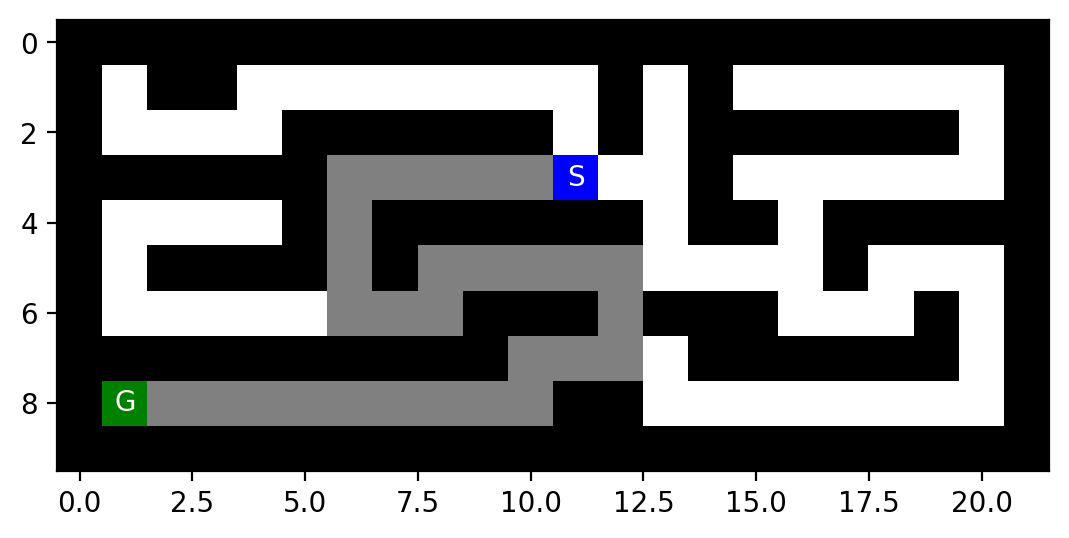

a star search



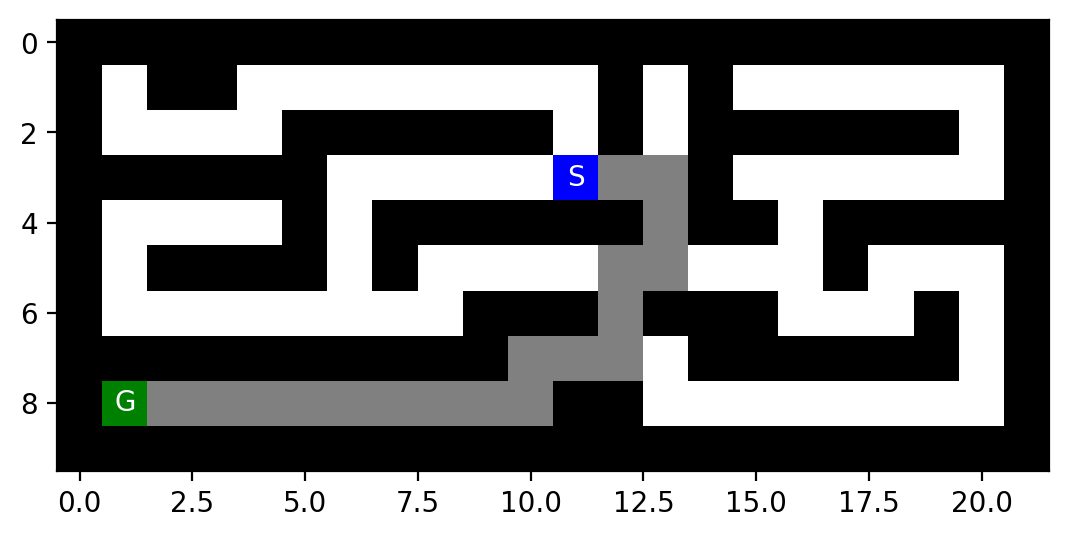


 medium_maze.txt 

greedy best-first search



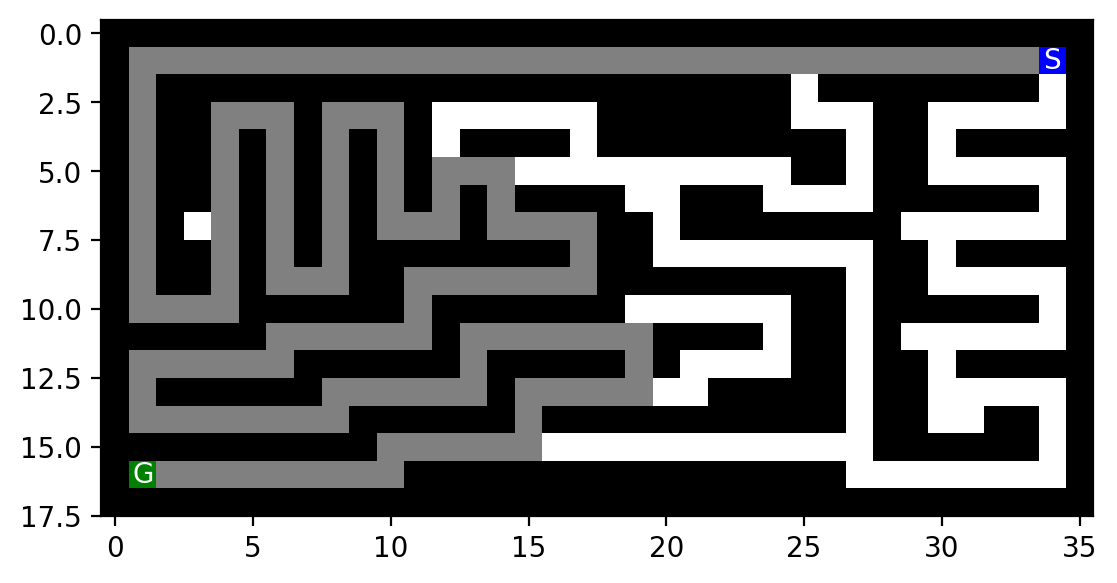

a star search



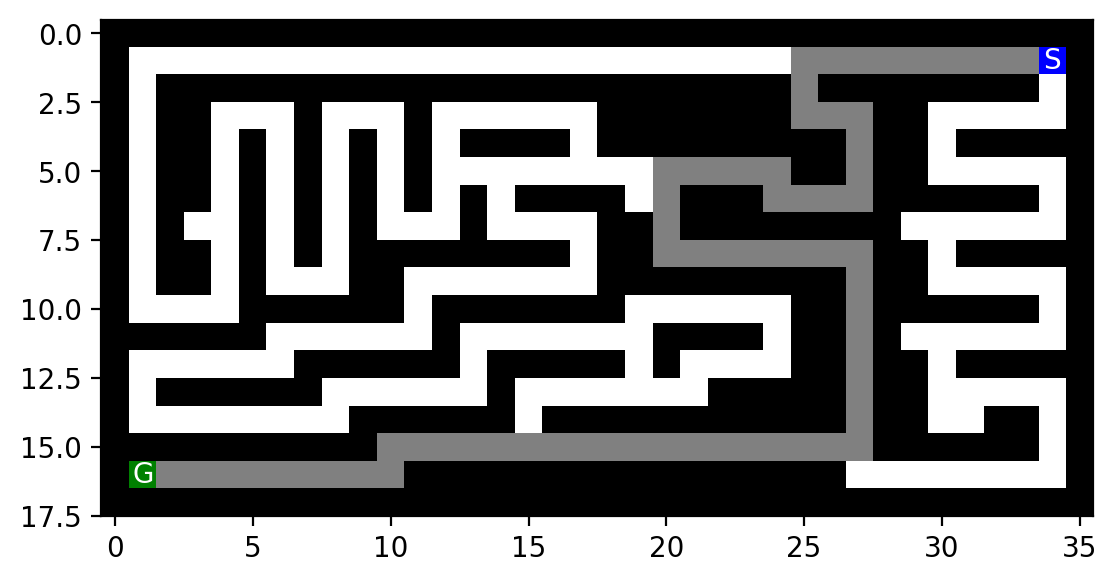


 large_maze.txt 

greedy best-first search



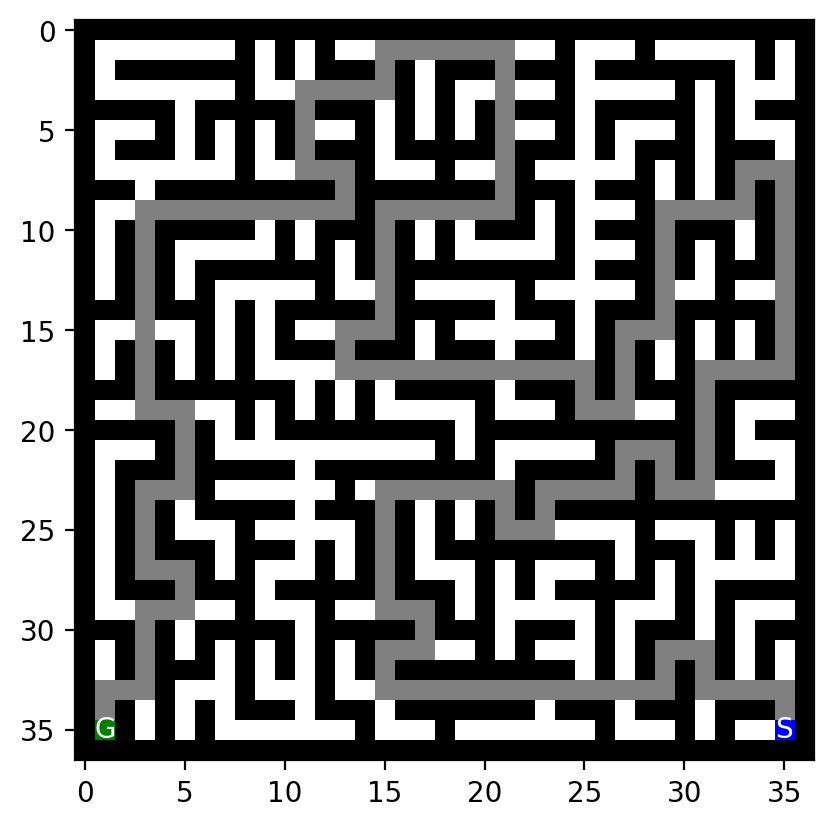

a star search



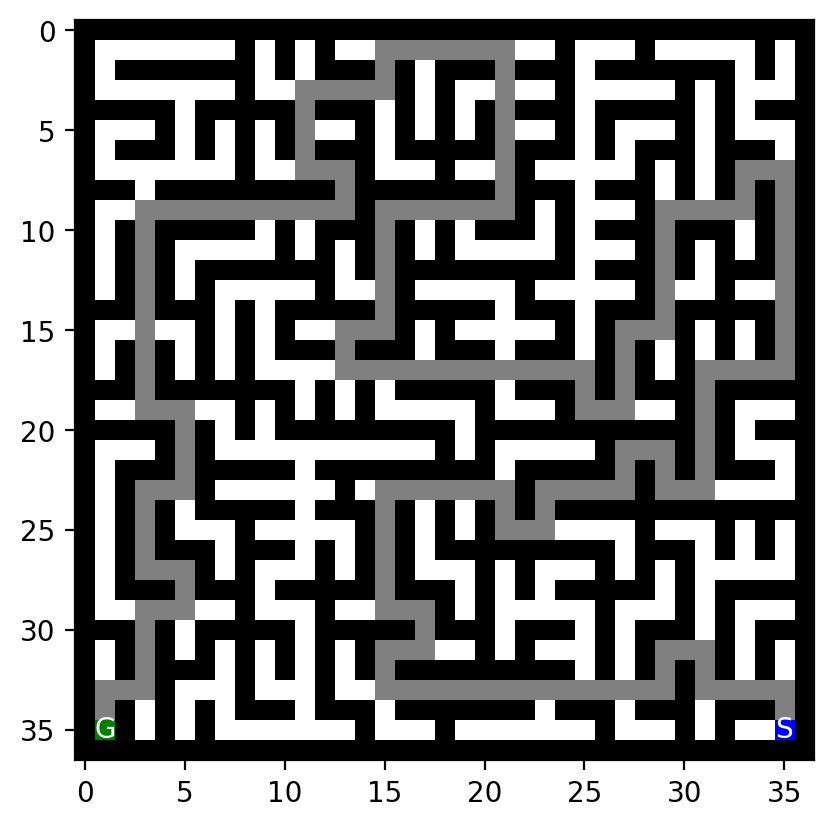


 open_maze.txt 

greedy best-first search



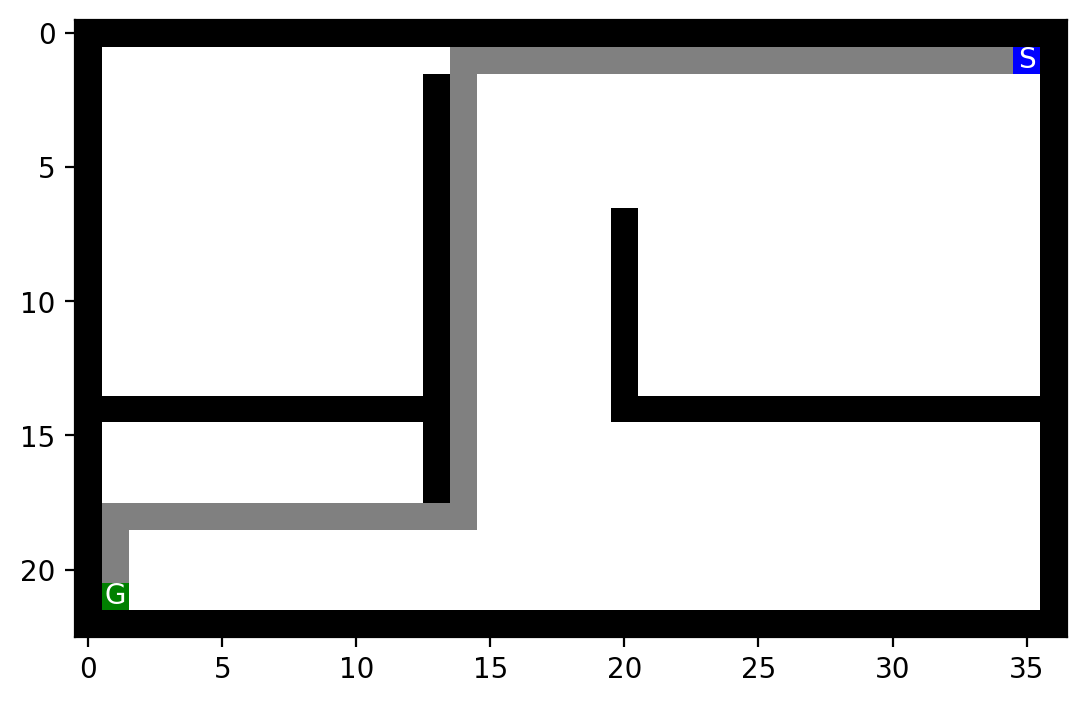

a star search



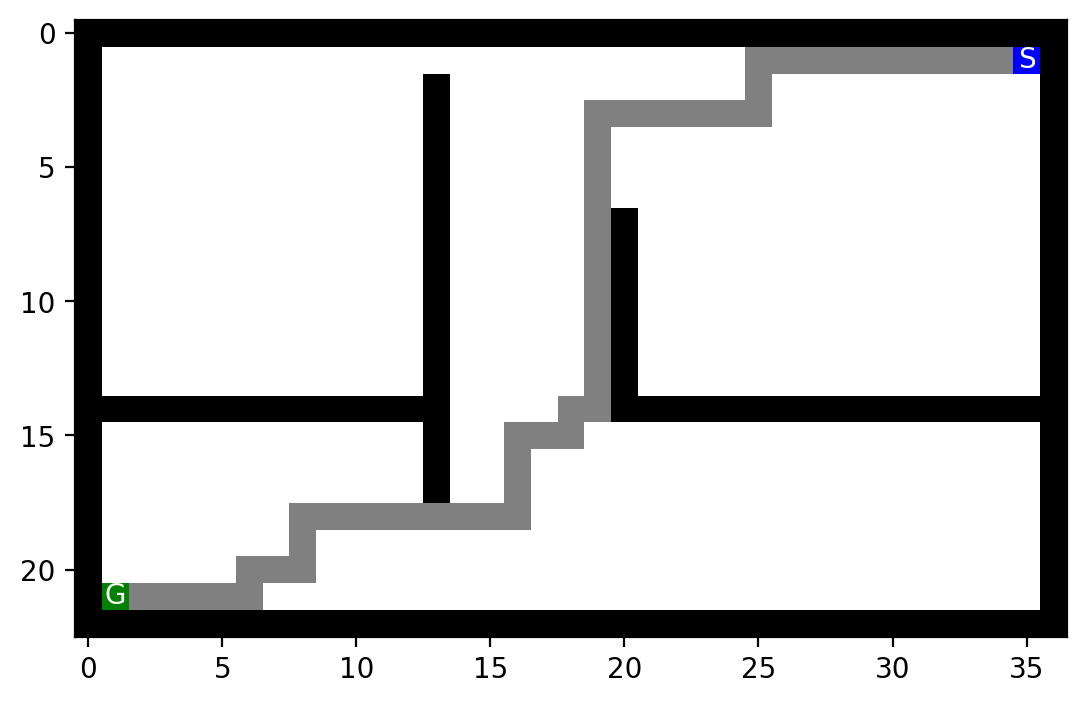


 wall_maze.txt 

greedy best-first search



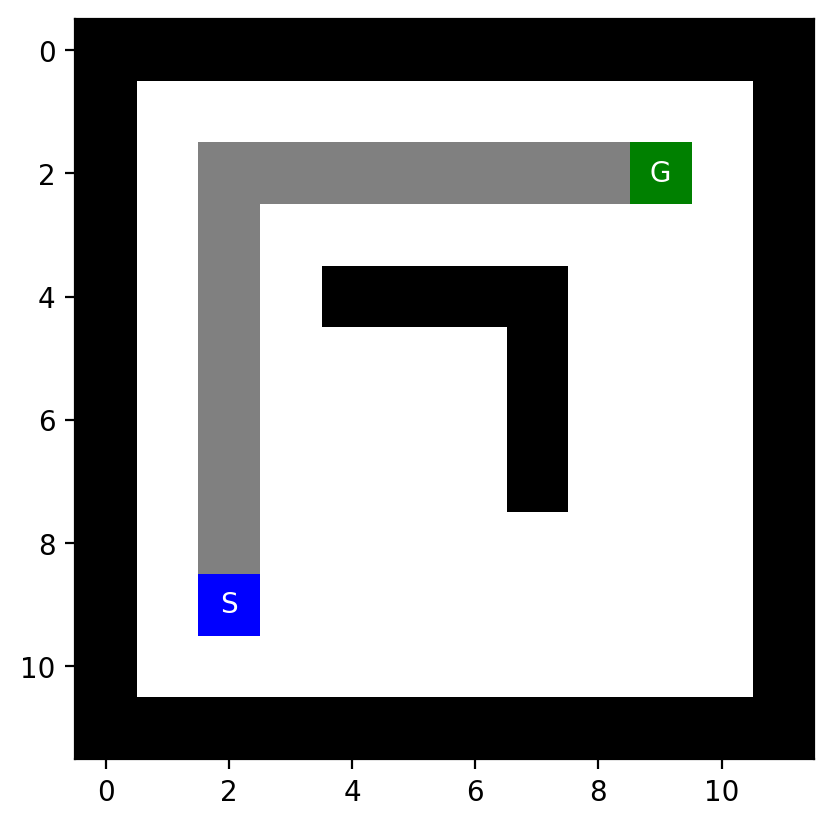

a star search



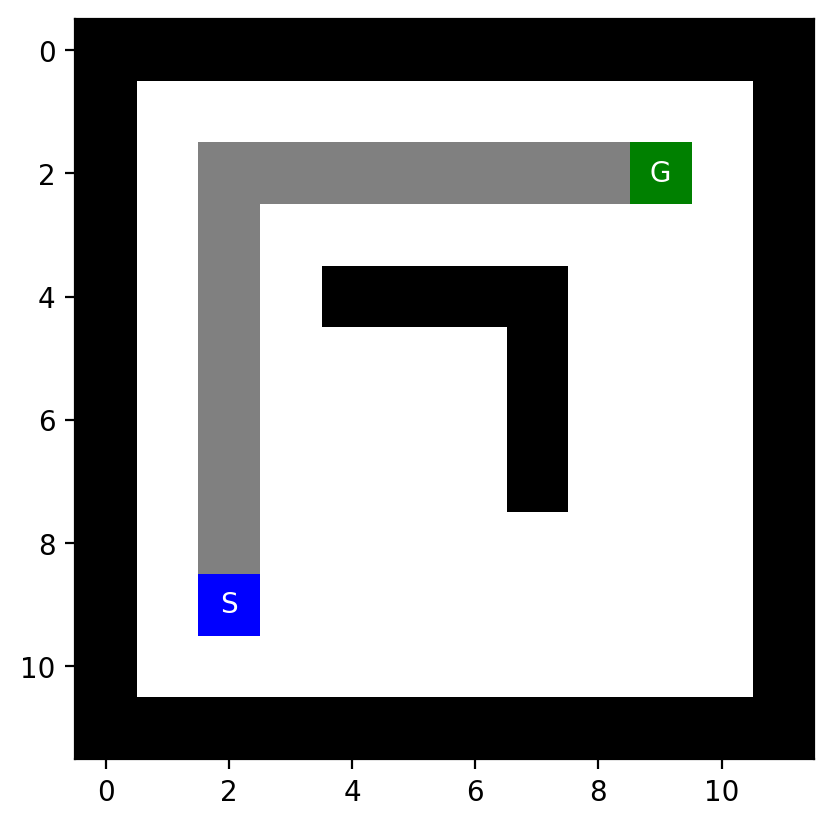


 loops_maze.txt 

greedy best-first search



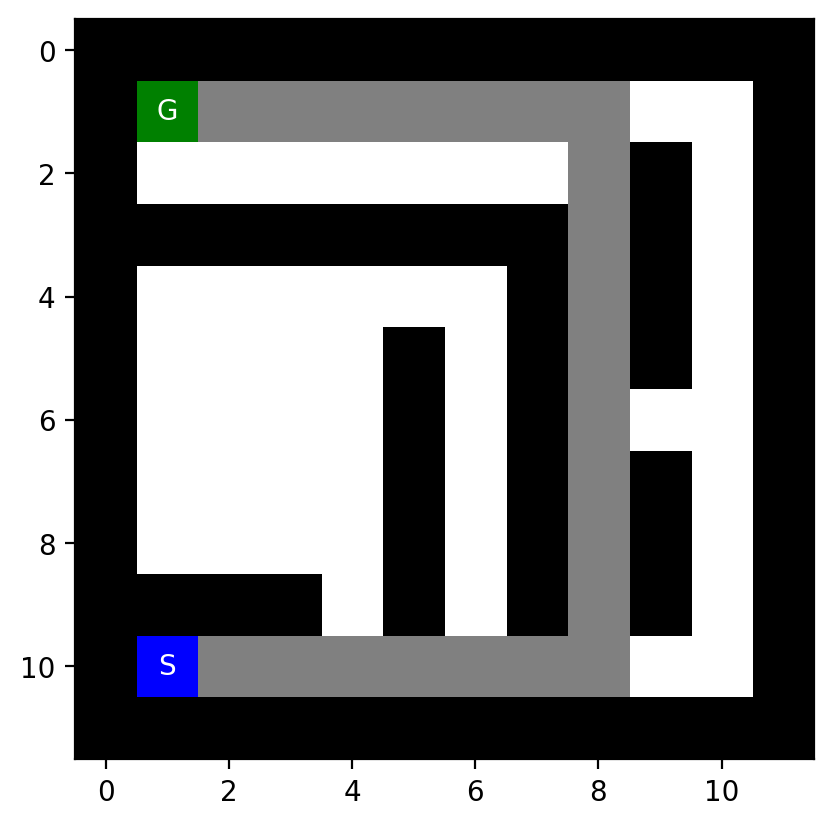

a star search



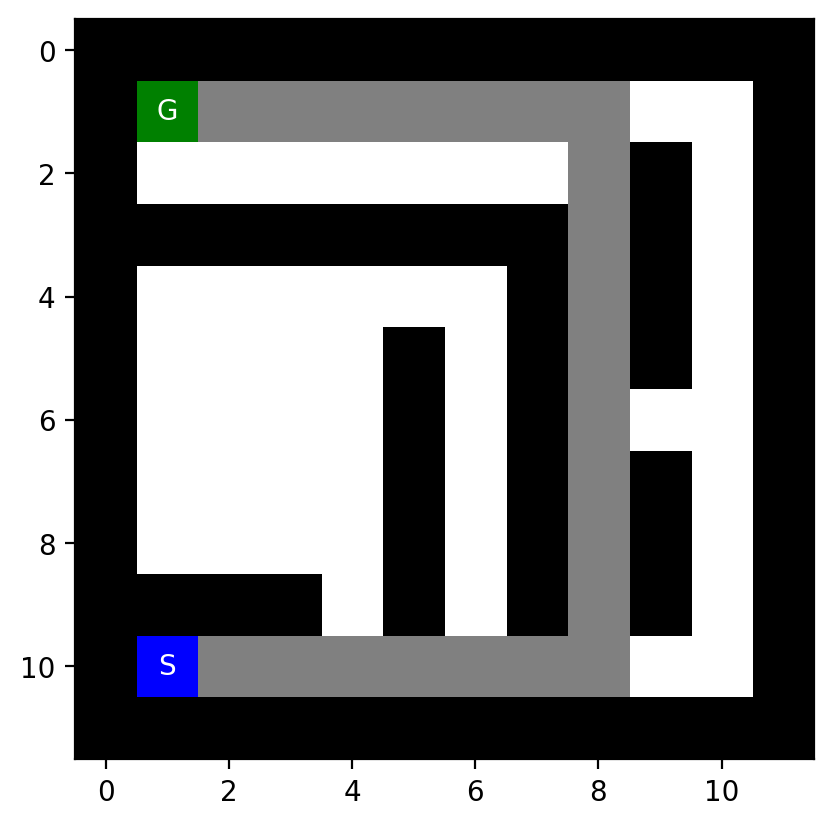


 empty_maze.txt 

greedy best-first search



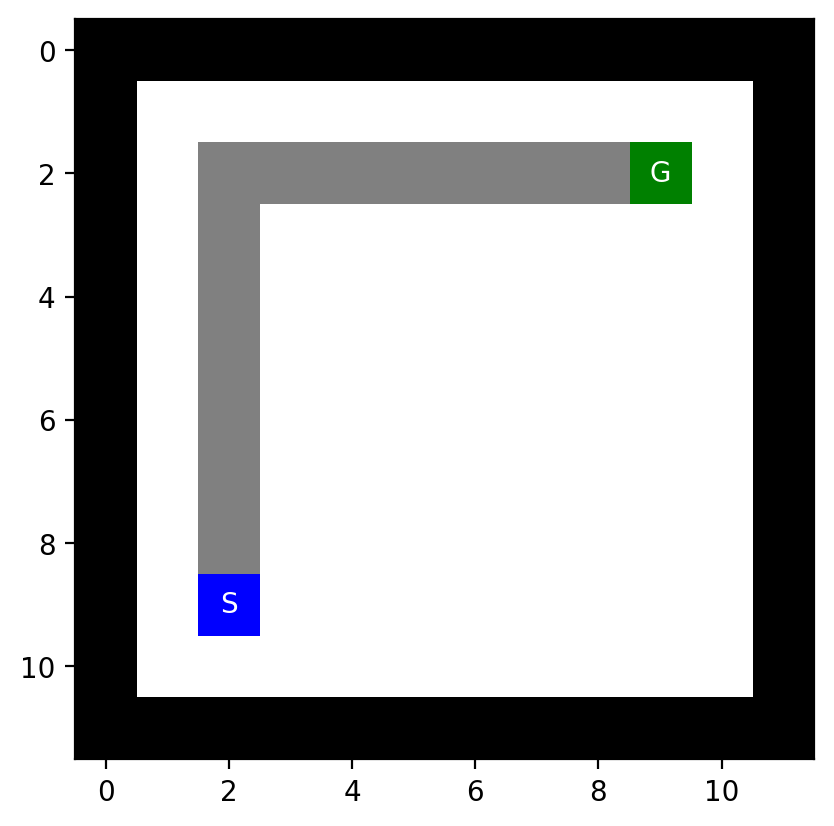

a star search



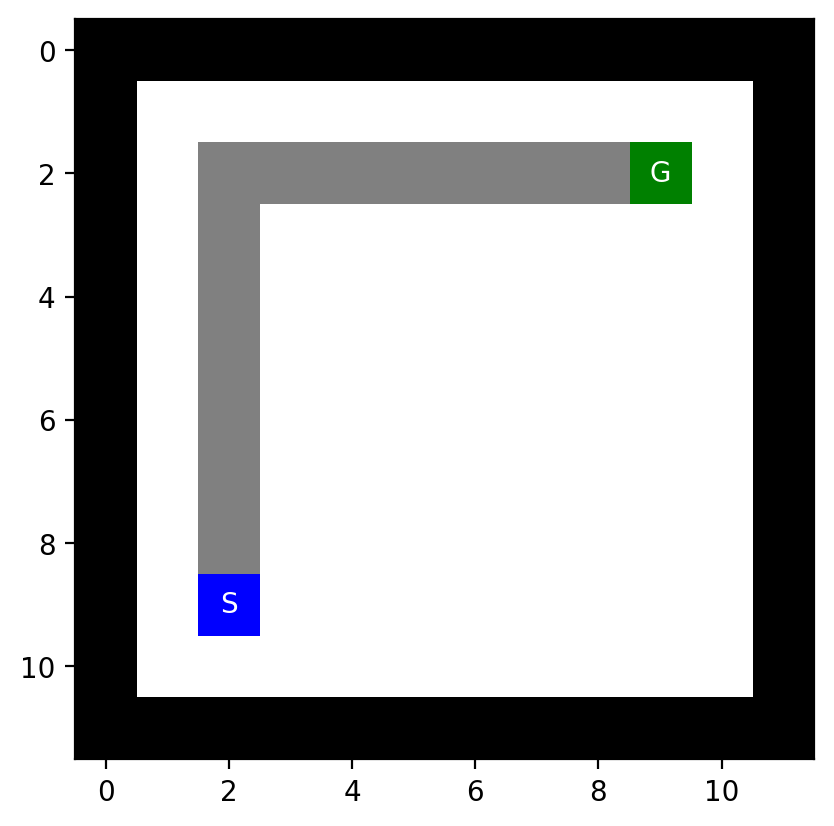


 empty_2_maze.txt 

greedy best-first search



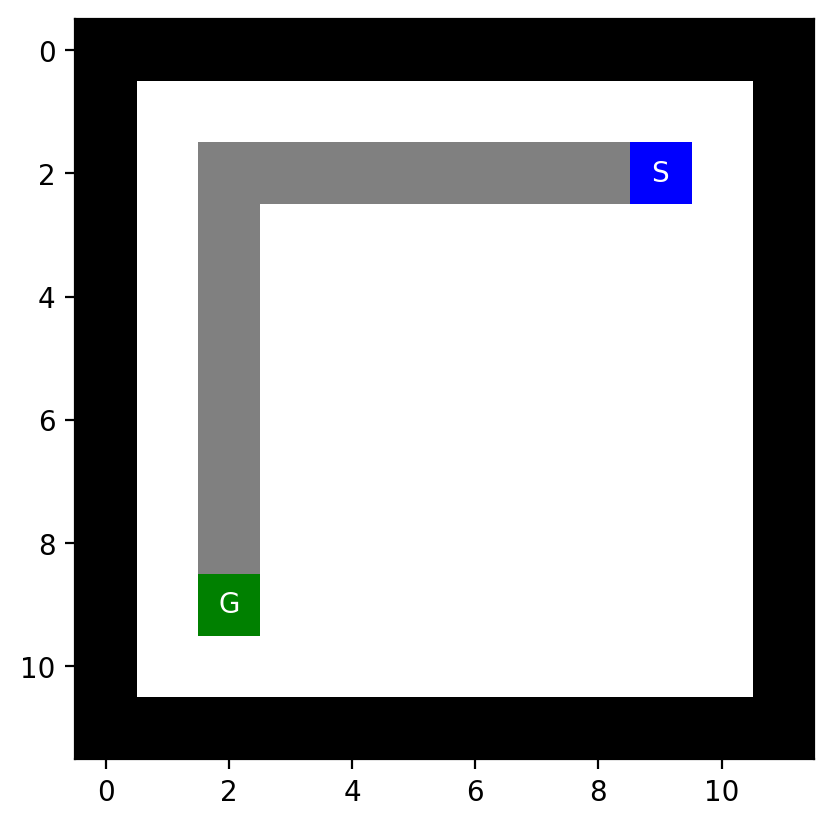

a star search



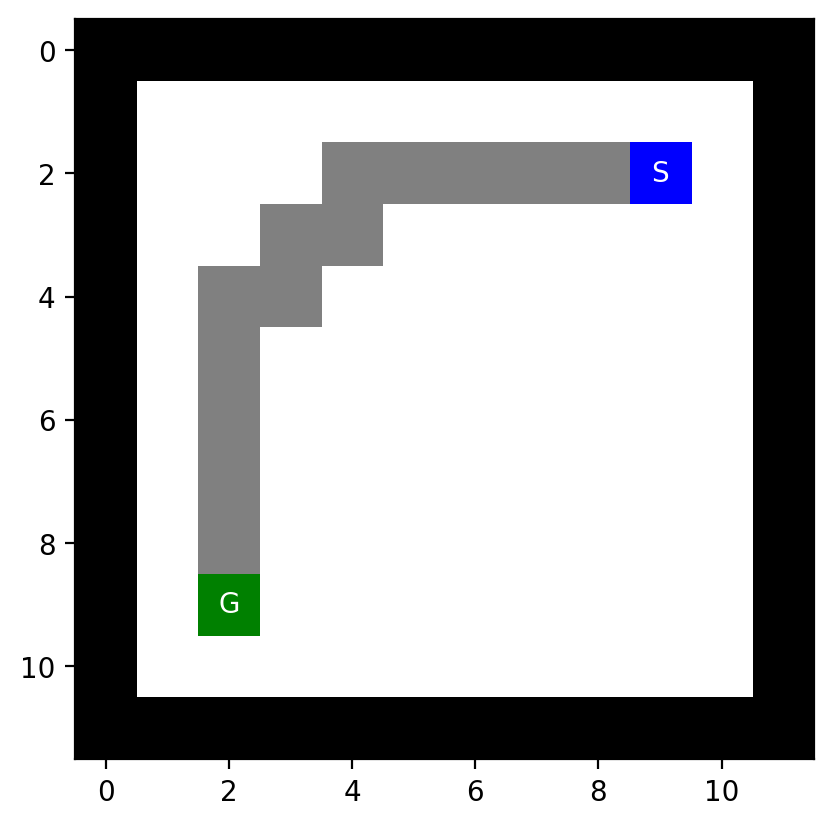

In [11]:
import heapq

def greedy_bestfs_maze_search(maze, heuristic):
    root = Node(mh.find_pos(maze, what='S'), None, None, 0)
    goal_node = mh.find_pos(maze, what='G')

    if root.pos == goal_node:
        return root.get_path_from_root()

    # Use a tuple with the heuristic value as the first element and a tiebreaker as the second
    frontier = [(heuristic(root, goal_node), root)]  
    reached = {mh.find_pos(maze, what='S'): root}

    while frontier:
        (_, cur_node) = heapq.heappop(frontier)

        children = get_surrounding_positions(maze, cur_node.pos)
        for child in children:
            s = Node(child, cur_node, None, cur_node.cost + 1)
            if child not in reached or cur_node.cost + 1 < reached[child].cost:
                if child == goal_node:
                    return s.get_path_from_root()

                reached[child] = s
                # Include a tiebreaker (cost) as the second element in the tuple
                heapq.heappush(frontier, (heuristic(s, goal_node), s))

    return None

# A* search implementation
def astar_maze_search(maze, heuristic):
    root = Node(mh.find_pos(maze, what='S'), None, None, 0)
    goal_node = mh.find_pos(maze, what='G')

    if root.pos == goal_node:
        return root.get_path_from_root()

    # Use a tuple with the heuristic value as the first element and a tiebreaker as the second
    frontier = [(heuristic(root, goal_node) + root.cost, root)]  
    reached = {mh.find_pos(maze, what='S'): root}

    while frontier:
        (_, cur_node) = heapq.heappop(frontier)

        children = get_surrounding_positions(maze, cur_node.pos)
        for child in children:
            s = Node(child, cur_node, None, cur_node.cost + 1)
            if child not in reached or cur_node.cost + 1 < reached[child].cost:
                if child == goal_node:
                    return s.get_path_from_root()

                reached[child] = s
                # Include a tiebreaker (cost) as the second element in the tuple
                heapq.heappush(frontier, (heuristic(s, goal_node) + s.cost, s))

    return None

def manhattan_distance(node, goal):
    x1, y1 = node.pos  # Access the pos attribute of the Node object
    x2, y2 = goal
    return abs(x1 - x2) + abs(y1 - y2)


maze_files = ["small_maze.txt", "medium_maze.txt", "large_maze.txt", 
               "open_maze.txt","wall_maze.txt", "loops_maze.txt", "empty_maze.txt", "empty_2_maze.txt"]

maze_data = {}
for file in maze_files:
    with open(file, "r") as f:
        maze_data[file] = f.read()
        
for maze, string in maze_data.items():
    print("\n", maze, "\n")
    maze = mh.parse_maze(string)
    start = mh.find_pos(maze, what = "S")
    goal = mh.find_pos(maze, what = "G")
    
    print("greedy best-first search\n")
    for node in greedy_bestfs_maze_search(maze, manhattan_distance):
        if node.pos != goal and node.pos != start:
            maze[node.pos[0]][node.pos[1]] = "."
    mh.show_maze(maze)
    maze = mh.parse_maze(string)
    
    print("a star search\n")
    for node in astar_maze_search(maze, manhattan_distance):
        if node.pos != goal and node.pos != start:
            maze[node.pos[0]][node.pos[1]] = "."
    
    mh.show_maze(maze)


Are your implementations complete and optimal? What is the time and space complexity?

In [ ]:
# Discussion

## Task 4: Comparison and discussion [20 Points]

Run experiments to compare the implemented algorithms.

How to deal with issues:

* Your implementation returns unexpected results: Try to debug and fix the code. Visualizing the maze, the current path and the frontier after every step is very helpful. If the code still does not work, then mark the result with an asterisk (*) and describe the issue below the table.

* Your implementation cannot consistently solve a specific maze and ends up in an infinite loop:
    Debug. If it is a shortcoming of the algorithm/implementation, then put "N/A*" in the results table and describe why this is happening.

In [ ]:
# Add code

Complete the following table for each maze.

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__
| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Small maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Large Maze__
| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |
__O maze__

| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |

__Medium Maze__
| algorithm | path cost | # of nodes expanded | max tree depth | max # of nodes in memory | max frontier size |
|-----------|-----------|----------------|----------------|---------------|-------------------|
| BFS       |           |                |                |               |                   |
| DFS       |           |                |                |               |                   |
| GBS       |           |                |                |               |                   |
| A*        |           |                |                |               |                   |


Present the results as using charts (see [Python Code Examples/charts and tables](../HOWTOs/charts_and_tables.ipynb)).

In [ ]:
# Add charts

Discuss the most important lessons you have learned from implementing the different search strategies.

In [ ]:
# Add discussion

---
Assignment adapted from [Michael Hahsler](https://github.com/mhahsler/CS7320-AI) under [CC BY-SA](https://creativecommons.org/licenses/by-sa/4.0/deed.en) license.